In [1]:
# https://www.cl.cam.ac.uk/~pms69/gpus.html

TRAINING_WAVEFN_FOURIER_MODES = 3   # 3
TRAINING_TIME = 0.5                 # 0.5 - 2.0
TRAINING_INITIALS = 200             # 200
TRAINING_T_STEPS = 50              # 50
TRAINING_EPOCHS = 1000             # 1000
LEARNING_RATE = 0.001              # 0.001
TRAINING_BATCH_SIZE = 1000         # 1000

HIDDEN_DIM = 500    # 500

USE_AUTOGRAD = False    # Using finite-difference uses significantly less memory and gives similar results.

PLOT_LOSSES = True

MSE_HYPERPARAM = 1         # 0.1
SCHRODINGER_HYPERPARAM = 0.1      # 1
BOUNDARY_HYPERPARAM = 0.025     # 0.25
INITIAL_CONDS_HYPERPARAM = 0.025   # 0.5
NORM_HYPERPARAM = 0.025             # 0.1
ENERGY_HYPERPARAM = 0.025          # 0.1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"

if device == "cuda":
    print(f"CUDA available. Using device \"{torch.cuda.get_device_name()}\".")
else:
    print(f"Using CPU device.")

CUDA available. Using device "Tesla P100-PCIE-16GB".


In [3]:
### NUMERICAL SIMULATOR ###
import scipy.integrate
def numerical_schrodinger(initials, ts, grid_size=100, grid_length=1):

    psi0 = initials[0:2, :, :]    
    v = initials[2, :, :]
    shape = psi0.shape
    flattened_shape = np.prod(shape)
    
    # flatten
    psi0 = np.reshape(psi0, flattened_shape)
    
    # construct laplacian operator and then Hamiltonian
    dx = grid_length/grid_size
    D2 = -2*np.eye(grid_size)
    for i in range(grid_size-1):
        D2[i,i+1] = 1 
        D2[i+1,i] = 1
    
    KE = -0.5*D2/(dx**2)
 
    def dpsi_dt(t,y):        
        y = np.reshape(y, shape)
        psi_real = y[0]
        psi_imag = y[1]
        dpsi_real = np.expand_dims(-KE@psi_imag - v*psi_imag, 0)
        dpsi_imag = np.expand_dims(KE@psi_real + v*psi_real, 0)
        return np.reshape(np.concatenate((dpsi_real, dpsi_imag), axis=0), flattened_shape)
    
    #sol = scipy.integrate.odeint(dpsi_dt, psi0, ts)
    sol = scipy.integrate.solve_ivp(dpsi_dt, t_span=[0,np.max(ts)], y0=psi0, t_eval=ts, method="RK23")
    
    return np.reshape(sol.y, shape+(len(ts),))

In [4]:
### TRAINING DATA ###
from tqdm import tqdm
import scipy.interpolate

class SimpleFiniteStepDataset(torch.utils.data.Dataset):
    def __init__(self, grid_size=100, grid_length=1, fourier_modes=TRAINING_WAVEFN_FOURIER_MODES, max_time=TRAINING_TIME, ntimes=TRAINING_T_STEPS, num_initials=TRAINING_INITIALS):
        self.grid_size = grid_size
        self.grid_length = grid_length
        self.fourier_modes = fourier_modes
        self.max_time = max_time
        self.ntimes = ntimes
        self.num_data = num_initials*ntimes*grid_size
        initials = np.empty((3, grid_size, num_initials))
        
        xs = np.linspace(0,grid_length,grid_size)
        
        print('Generating Initials')
        for i in range(num_initials):
            psi0_real, psi0_imag, v = self._generate_initial()
            initials[0, :, i] = psi0_real.T
            initials[1, :, i] = psi0_imag.T
            initials[2, :, i] = v.T
        print('Finished generating initials.')
        
        ts = np.linspace(0, max_time, ntimes)
        integrated = numerical_schrodinger(initials, ts, grid_size, grid_length)
        
        self.data = []
        
        print('the end bit is slow. Starting it now.')
        for i in range(self.num_data):
            a = i%self.ntimes                 # time index
            b = int(i/self.ntimes)%grid_size  # space index
            c = int(i/self.ntimes/grid_size)  # psi0 index
            
            x_real = initials[0,:,c]
            x_imag = initials[1,:,c]
            x_potl = initials[2,:,c]
            
            x = np.concatenate((np.array([xs[b], ts[a]]), x_real, x_imag, x_potl))
            
            y_real = integrated[0,b,c,a]
            y_imag = integrated[1,b,c,a]
            
            y = np.array([y_real, y_imag])
            
            x = torch.tensor(x).float()
            y = torch.tensor(y).float()
            
            self.data.append([x,y])
            
        print('did the end bit')
        
    def __len__(self):
        return self.num_data
    
    def __getitem__(self, index):    
        return self.data[index]
                
    def _generate_initial(self):
        
        # create the initial wave function
        fourier_real_coefficients = 2*np.random.rand(self.fourier_modes)-1
        fourier_imag_coefficients = 2*np.random.rand(self.fourier_modes)-1
        n = np.arange(start=1, stop=self.fourier_modes+1, step=1)

        scale_factor = np.sum(fourier_real_coefficients**2) + np.sum(fourier_imag_coefficients**2)
        scale_factor = (2/(self.grid_length*scale_factor))**0.5
        fourier_real_coefficients *= scale_factor
        fourier_imag_coefficients *= scale_factor
        
        def init_wave_function(x):
            x = np.pi*x/self.grid_length
            psi_real = np.sin(np.outer(x, n))
            psi_real = psi_real*fourier_real_coefficients
            psi_real = np.sum(psi_real, axis=-1)
            
            psi_imag = np.sin(np.outer(x, n))
            psi_imag = psi_imag*fourier_imag_coefficients
            psi_imag = np.sum(psi_imag, axis=-1)
            
            return psi_real, psi_imag
        
        
        # TODO: change when we have a better potential
        potential_function = lambda x: 0*x
        
        x = np.linspace(0, self.grid_length, self.grid_size)
        psi_real, psi_imag = init_wave_function(x)
        v = potential_function(x)
        
        return psi_real, psi_imag, v
        
    

In [5]:
# Generate training data
import time

print('Generating data...')
start = time.perf_counter()
data = SimpleFiniteStepDataset(grid_size=100, fourier_modes=TRAINING_WAVEFN_FOURIER_MODES, max_time=TRAINING_TIME, ntimes=TRAINING_T_STEPS, num_initials=TRAINING_INITIALS)
end = time.perf_counter()
print(f'Training data generated after {end-start} seconds!')

Generating data...
Generating Initials
Finished generating initials.
the end bit is slow. Starting it now.
did the end bit
Training data generated after 48.167880362000005 seconds!


In [6]:
### INTERPOLATE HELPER ###
def batch_interp(funcs, xs):
    batch_size = funcs.shape[0]
    grid_length = funcs.shape[1]
    
    left_pos = torch.zeros((batch_size,1)).type(torch.LongTensor).to(device)
    left_pos[:,0] = torch.floor(xs*grid_length)
    
    right_pos = left_pos.clone()
    right_pos += 1
    
    min_pos = torch.zeros_like(left_pos)
    max_pos = torch.zeros_like(left_pos)
    max_pos += grid_length - 1
    
    right_pos = torch.maximum(torch.minimum(right_pos, max_pos), min_pos)
    left_pos = torch.maximum(torch.minimum(left_pos, max_pos), min_pos)
    
    s = torch.zeros((batch_size,1)).to(device)
    s[:,0] = xs*grid_length - torch.floor(xs*grid_length)
    
    left_sample = torch.gather(funcs, 1, left_pos)
    right_sample = torch.gather(funcs, 1, right_pos)
    
    return (1-s)*left_sample + s*right_sample


# SIMPLIFIED BAD INTERPOLATION FUNCTION
# def batch_interp(funcs, xs):
#     # Have tried adding/removing the two lines below.
#     # funcs = funcs.clone()
#     # xs = xs.clone()
    
#     batch_size = funcs.shape[0]
#     grid_length = funcs.shape[1]
    
#     pos = torch.zeros((batch_size,1)).type(torch.LongTensor).to(device)
#     pos[:,0] = 50
    
#     sample = torch.gather(funcs, 1, pos)
    
#     return sample

# TESTING
# fn = torch.tensor([[1,2,3,1,2,3,1,2,3]]*1000).to(device)
# xs = torch.linspace(-1,2,1000).to(device)
# outs = batch_interp(fn,xs).cpu().detach().numpy()
# import matplotlib.pyplot as plt
# plt.plot(xs.cpu().detach().numpy(),outs)
    

In [7]:
### MODEL DEFN ###
class SimpleFiniteStepSolver(nn.Module):
    def __init__(self, grid_size=100, hidden_dim=300):
        super(SimpleFiniteStepSolver, self).__init__()
        
        self.grid_size = grid_size

        self.mlp = nn.Sequential(
            nn.Linear(3*grid_size+2, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.mlp(x)

In [8]:
### TRAIN MODEL AND SPECIFY LOSS FUNCTIONS ###
from tqdm import tqdm
import matplotlib.pyplot as plt # DEBUG TMP

nepochs = TRAINING_EPOCHS
model = SimpleFiniteStepSolver(grid_size=100, hidden_dim=HIDDEN_DIM).to(device)

train_data_loader = torch.utils.data.DataLoader(data, batch_size=TRAINING_BATCH_SIZE, shuffle=True)

optm = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

mse_hyperparam = MSE_HYPERPARAM
schrod_hyperparam = SCHRODINGER_HYPERPARAM
bc_hyperparam = BOUNDARY_HYPERPARAM
ic_hyperparam = INITIAL_CONDS_HYPERPARAM
norm_hyperparam = NORM_HYPERPARAM
energy_hyperparam = ENERGY_HYPERPARAM

grid_size = model.grid_size

losses = [[],[],[],[],[],[],[],[]]

# Schrödinger equation loss
def schrodinger_loss(output, inputs):
    batch_size = output.shape[0]
    
    psi_real = output[:,0]
    psi_imag = output[:,1]
    
    # Calculate Laplacian
    if USE_AUTOGRAD:
        e_x = torch.zeros((batch_size,302)).to(device)
        e_x[:,0] = 1
        psi_dx = lambda i: torch.autograd.functional.jvp(model, i, v=e_x, create_graph=True)[1]
        psi_d2x = torch.autograd.functional.jvp(psi_dx, inputs, v=e_x, create_graph=True)[1]
    else:
        dx = 1e-2 # TODO Make sure the precsion of this is no less than the precision of input
        inputs_x_minus = inputs.clone()
        inputs_x_minus[:,0] -= dx
        inputs_x_plus = inputs.clone()
        inputs_x_plus[:,0] += dx

        psi_x_minus = model(inputs_x_minus)
        psi_x_plus = model(inputs_x_plus)
        psi_d2x = (psi_x_plus + psi_x_minus - 2*output)/(dx**2)
    
    psi_d2x_real = psi_d2x[:,0]
    psi_d2x_imag = psi_d2x[:,1]
    
    # Calculate time derivative
    if USE_AUTOGRAD:
        e_t = torch.zeros((batch_size,302)).to(device)
        e_t[:,1] = 1
        psi_dt = torch.autograd.functional.jvp(model, inputs, v=e_t, create_graph=True)[1]
    else:
        dt = 1e-5
        inputs_t_minus = inputs.clone()
        inputs_t_minus[:,1] -= dt
        inputs_t_plus = inputs.clone()
        inputs_t_plus[:,1] += dt

        psi_t_minus = model(inputs_t_minus)
        psi_t_plus = model(inputs_t_plus)
        psi_dt = (psi_t_plus - psi_t_minus)/(2*dt)
    
    psi_dt_real = psi_dt[:,0]
    psi_dt_imag = psi_dt[:,1]
    
    # Calculate potential energy
    # V_grid = inputs[:,2*grid_size+2:]
    # V = batch_interp(V_grid,inputs[:,0])
    V = 0
    
    V_real = V * psi_real
    V_imag = V * psi_imag
    
    # Calculate loss
    diff_1 = psi_dt_real - 0.5*psi_d2x_imag + V_imag
    diff_2 = psi_dt_imag + 0.5*psi_d2x_real - V_real

    return torch.mean(diff_1**2 + diff_2**2)

# Boundary condition loss
def bc_loss(inputs):    
    inputs_left = inputs.clone()
    inputs_left[:,0] = 0
    outputs_left = model(inputs_left)
    
    inputs_right = inputs.clone()
    inputs_right[:,0] = 1
    outputs_right = model(inputs_right)
    
    return torch.mean(outputs_left**2 + outputs_right**2)

# Initial condition loss
def ic_loss(inputs):    
    inputs_initial = inputs.clone()
    inputs_initial[:,1] = 0
    outputs_initial = model(inputs_initial)
    
    psi0_real = inputs[:,2:grid_size+2]
    psi0_imag = inputs[:,grid_size+2:2*grid_size+2]
    xs = inputs[:,0]
    
    targets_real = batch_interp(psi0_real, xs)
    targets_imag = batch_interp(psi0_imag, xs)
    
    return torch.mean((outputs_initial[:,0] - targets_real[:,0])**2 + (outputs_initial[:,1] - targets_imag[:,0])**2)

# Gaussian Quadrature Coefficients
legendre_n = 10
legendre_xs, legendre_ws = scipy.special.roots_legendre(legendre_n)
legendre_xs = (legendre_xs + 1.0)/2.0
legendre_xs = torch.tensor(legendre_xs).to(device).float()
legendre_ws = torch.tensor(legendre_ws).to(device).float()

# Normalisation Loss
def norm_loss(inputs):
    batch_size = inputs.shape[0]
    inputs_clone = inputs.clone()
    inputs_clone = inputs_clone.expand(legendre_n,-1,-1).clone()
    xs_expanded = legendre_xs.expand(batch_size, -1).T
    inputs_clone[:,:,0] = xs_expanded
    inputs_clone = torch.reshape(inputs_clone, (batch_size*legendre_n, -1))
    outputs = model(inputs_clone)
    outputs = torch.reshape(outputs, (legendre_n, batch_size, -1))
    outputs = outputs[:,:,0]**2 + outputs[:,:,1]**2
    norms = torch.inner(outputs.T, legendre_ws)/2
    return torch.mean((norms-1)**2)

# Energy Conservation Loss
def energy_loss(inputs):
    # Reshape input to evalute at legendre_n number of points.
    batch_size = inputs.shape[0]
    inputs_clone = inputs.clone()
    inputs_clone = inputs_clone.expand(legendre_n,-1,-1).clone()
    xs_expanded = legendre_xs.expand(batch_size, -1).T
    inputs_clone[:,:,0] = xs_expanded
    inputs_clone = torch.reshape(inputs_clone, (batch_size*legendre_n, -1))

    # TODO we don't have V(x) term yet. 
    psi = model(inputs_clone)
    psi = torch.reshape(psi, (legendre_n, batch_size, -1))

    normalisation = torch.inner((psi[:,:,0]**2 + psi[:,:,1]**2).T, legendre_ws)/2

    if USE_AUTOGRAD:
        e_x = torch.zeros((inputs_clone.shape[0],302)).to(device)
        e_x[:,0] = 1
        psi_dx = torch.autograd.functional.jvp(model, inputs_clone, v=e_x, create_graph=True)[1]
    else:
        dx = 1e-5
        inputs_x_minus = inputs_clone.clone()
        inputs_x_minus[:,0] -= dx
        inputs_x_plus = inputs_clone.clone()
        inputs_x_plus[:,0] += dx

        psi_x_minus = model(inputs_x_minus)
        psi_x_plus = model(inputs_x_plus)
        psi_dx = (psi_x_plus - psi_x_minus)/(2*dx)

    psi_dx = torch.reshape(psi_dx, (legendre_n, batch_size, -1))

    # Now use <H> = int 0.5*(psi_dx) + V(x)[psi^2].
    psi_h_psi = 0.5*(psi_dx[:,:,0]**2 + psi_dx[:,:,1]**2) # + v(x)*(psi[:,:,0]**2 + psi[:,:,1]**2)
    expectation_energy_after = torch.inner(psi_h_psi.T, legendre_ws)/2/normalisation

    # Calculate initial energy expectation
    psi_0_real = inputs[:,2:102]
    psi_0_imag = inputs[:,102:202]
    # v = inputs[:,202:]
    psi_0_real_dx = (psi_0_real[:,1:] - psi_0_real[:,:-1])*100 
    psi_0_imag_dx = (psi_0_imag[:,1:] - psi_0_imag[:,:-1])*100

    initial_expectation = torch.sum(0.5*(psi_0_real_dx**2 + psi_0_imag_dx**2), dim=1)/99

    # TODO CHANGE THIS TO 1-AFTER/INITIAL.
    return torch.mean((1 - expectation_energy_after / initial_expectation)**2)


def custom_loss(output, inputs, target, epoch=None):    
    mse =  F.mse_loss(output,target)
    schrod_loss = schrodinger_loss(output, inputs) if schrod_hyperparam != 0 else 0
    bcds_loss = bc_loss(inputs) if bc_hyperparam != 0 else 0
    ics_loss = ic_loss(inputs) if ic_hyperparam != 0 else 0
    norm_loss_value = norm_loss(inputs) if norm_hyperparam != 0 else 0
    energy_loss_value = energy_loss(inputs) if energy_hyperparam != 0 else 0

    if epoch != None:
        losses[1][epoch] += mse.cpu().detach().numpy()
        losses[2][epoch] += schrod_loss.cpu().detach().numpy() if schrod_hyperparam != 0 else 0
        losses[3][epoch] += bcds_loss.cpu().detach().numpy() if bc_hyperparam != 0 else 0
        losses[4][epoch] += ics_loss.cpu().detach().numpy() if ic_hyperparam != 0 else 0 
        losses[5][epoch] += norm_loss_value.cpu().detach().numpy() if norm_hyperparam != 0 else 0 
        losses[6][epoch] += energy_loss_value.cpu().detach().numpy() if energy_hyperparam != 0 else 0

    return (
        mse_hyperparam*mse
         + bc_hyperparam*bcds_loss
         + ic_hyperparam*ics_loss
         + schrod_hyperparam*schrod_loss 
         + norm_hyperparam*norm_loss_value
         + energy_hyperparam*energy_loss_value
         )
    

for epoch in range(nepochs):
    # Slow down after kinda small 
    # if mse_loss < 6e-1:
    #     for g in optm.param_groups:
    #         g['lr'] = 0.0001

    epoch_loss = 0
    mse_loss = 0

    losses[0].append(0)
    losses[1].append(0)
    losses[2].append(0)
    losses[3].append(0)
    losses[4].append(0)
    losses[5].append(0)
    losses[6].append(0)
    
    for x,y in tqdm(train_data_loader):
        x = x.to(device)
        y = y.to(device)
        
        optm.zero_grad()
        output = model(x)     
        loss = custom_loss(output,x,y, epoch)
        
        loss.backward()
        optm.step()

        mse_loss += F.mse_loss(output,y)/len(train_data_loader)
        epoch_loss+=loss/len(train_data_loader)

    losses[0][epoch] = epoch_loss.cpu().detach().numpy()
        
    print('Epoch {} Loss : {:.3e} \t (MSE Loss {:.3e})'.format((epoch+1),epoch_loss, mse_loss))

    if PLOT_LOSSES:
        plt.figure(figsize=(7,7))
        plt.plot(losses[0])
        plt.plot(losses[1]/len(train_data_loader))
        plt.plot(losses[2]/len(train_data_loader))
        plt.plot(losses[3]/len(train_data_loader))
        plt.plot(losses[4]/len(train_data_loader))
        plt.plot(losses[5]/len(train_data_loader))
        plt.plot(losses[6]/len(train_data_loader))
        plt.yscale('log')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Total', 'MSE', 'BCs', 'ICs', 'Schrod.', 'Norm', 'Energy'])
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [9]:
steps = 200
T = TRAINING_TIME
ts = np.linspace(0,T,steps)

grid_length = 1
grid_size = model.grid_size

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def solve_single_numerically(psi0, v, ts, grid_size=grid_size, grid_length=grid_length):
    xs_num = np.linspace(0,grid_length,grid_size)
    p0_real, p0_imag = psi0(xs_num)
    vs = v(xs_num)
    
    initials = np.zeros((3, grid_size, 1))
    initials[0, :, 0] = p0_real.T
    initials[1, :, 0] = p0_imag.T
    initials[2, :, 0] = vs.T
    
    num_y = numerical_schrodinger(initials, ts, grid_size=grid_size)
    
    num_ys_real = num_y[0,:,0,:]
    num_ys_imag = num_y[1,:,0,:]
    
    return num_ys_real.T, num_ys_imag.T


def solve_single_nn(psi0, v, ts, grid_size=grid_size, grid_length=grid_length):
    xs = torch.linspace(0, grid_length, grid_size).float()
    ts = torch.tensor(ts).float()
    p0_real, p0_imag = psi0(xs)
    vs = v(xs)
    
    if not torch.is_tensor(ts):
        ts = torch.tensor(ts)
        
    xts = torch.cartesian_prod(xs,ts)
#     xs_meshed = xts[:,0]
#     ts_meshed = xts[:,1]
    
    nn_in = torch.zeros((len(xts), 3*grid_size + 2))
    nn_in[:,0:2] = xts
    nn_in[:,2:] = torch.cat((p0_real, p0_imag, vs))
    nn_in = nn_in.to(device)
    
    nn_out = model(nn_in).cpu().detach().numpy()
    
    out_real = np.reshape(nn_out[:,0], (grid_size, len(ts))).T
    out_imag = np.reshape(nn_out[:,1], (grid_size, len(ts))).T 
    
    return out_real, out_imag
    

def test_model(psi0, v, plot_phase=False):
    # Solve numerically
    print('Solving numerically...')
    num_ys_real,num_ys_imag = solve_single_numerically(psi0, v, ts, grid_size, grid_length)
    print('Finished solving numerically.')
   
    # Solve using our method
    print('Solving nn...')
    nn_ys_real, nn_ys_imag = solve_single_nn(psi0, v, ts, grid_size, grid_length)
    print('Finished solving nn.')
    
    xs = np.linspace(0, grid_length, grid_size)
    
    # Normalisation vs time
    fig = plt.figure(figsize=(5,5))
    plt.plot(ts, np.sum(nn_ys_real**2 + nn_ys_imag**2, axis=1)*grid_length / grid_size)
    fig.suptitle('Normalisation')
    plt.xlabel('Time')
    plt.ylabel('∫|Ψ|² dx')
    
    # Plot animations
    fig = plt.figure(figsize=(12,8))
    
    plt.rcParams["animation.html"] = "html5"
    plt.rcParams["figure.dpi"] = 75
    
    # Helper for setting up subplot limits and labels
    def setup_subplot(subplot, prop):
        prop = prop.upper()
        if not prop in ["REAL", "IMAG", "ABS", "PHASE"]:
            raise ValueError(f'Bad property \'{prop}\'.')
        subplot.set_xlim(0,grid_length)
        if prop in ["REAL", "IMAG"]:
            subplot.set_ylim(-2,2)
            subplot.set_ylabel("Real" if prop == "REAL" else "Imaginary")
        if prop == "ABS":
            subplot.set_ylim(0,2)
            subplot.set_ylabel("Magnitude")
        if prop == "PHASE":
            subplot.set_ylim(-np.pi,np.pi)
            subplot.set_ylabel("Phase")
            subplot.set_yticks(np.arange(-np.pi,np.pi,np.pi/4))
        
        line, = subplot.plot([],[], lw=2)
        return line
    
    # Types of each subplot
    props = [None]*4
    if plot_phase:
        props = ["ABS", "ABS", "PHASE", "PHASE"]
    else:
        props = ["REAL", "REAL", "IMAG", "IMAG"]
       
    subplots = [None]*4
    lines = [None]*4
    for i in range(4):
        subplots[i] = plt.subplot(2,2,i+1)
        lines[i] = setup_subplot(subplots[i], props[i])
        
    subplots[0].title.set_text('NN model')
    subplots[1].title.set_text('Numerical model')
    
    def animate(i):
        if plot_phase:
            lines[0].set_data(xs, np.sqrt(nn_ys_real[i,:]**2 + nn_ys_imag[i,:]**2))
            lines[2].set_data(xs, np.arctan2(nn_ys_real[i,:], nn_ys_imag[i,:]))
        
            lines[1].set_data(xs, np.sqrt(num_ys_real[i,:]**2 + num_ys_imag[i,:]**2))
            lines[3].set_data(xs, np.arctan2(num_ys_real[i,:], num_ys_imag[i,:]))

        else:
            lines[0].set_data(xs, nn_ys_real[i,:])
            lines[2].set_data(xs, nn_ys_imag[i,:])
            
            lines[1].set_data(xs, num_ys_real[i,:])
            lines[3].set_data(xs, num_ys_imag[i,:])

        return lines
    
    anim = animation.FuncAnimation(fig, animate, frames=len(ts), interval=50, blit=True)
    HTML(anim.to_html5_video())
    return anim

Solving numerically...
Finished solving numerically.
Solving nn...
Finished solving nn.


/usr/local/lib/python3.7/dist-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


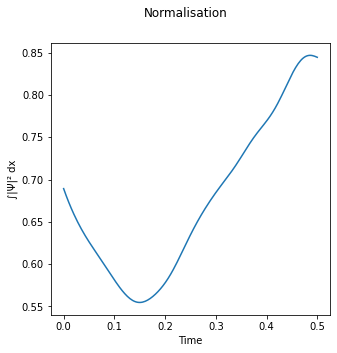

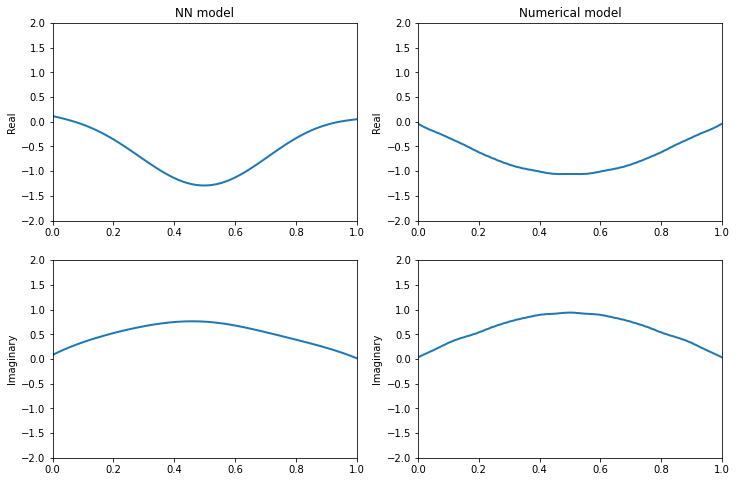

In [10]:
# Particle in a Box Ground State - Real+Imag

def psi0(x):
    real = np.sqrt(2)*np.sin(np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=False)

Solving numerically...
Finished solving numerically.
Solving nn...
Finished solving nn.


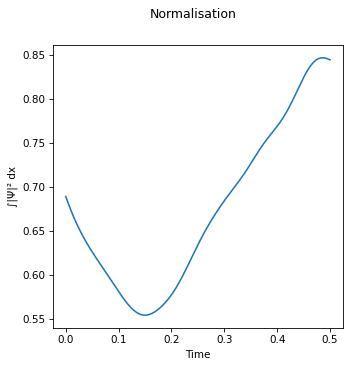

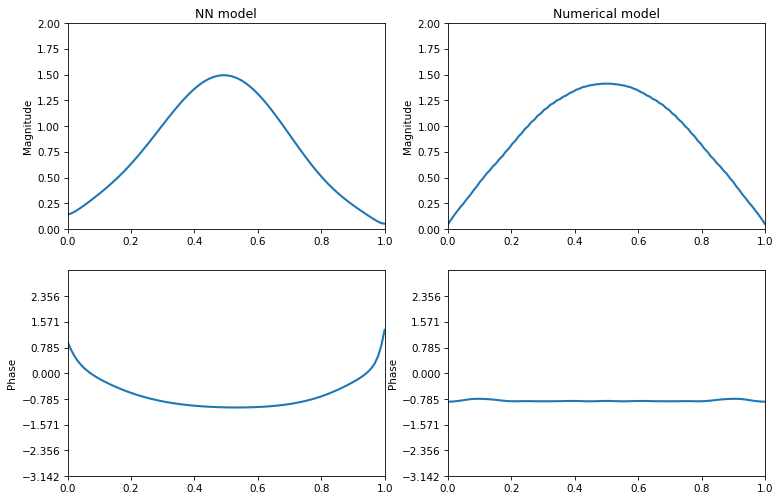

In [11]:
# Particle in a Box Ground State - Amplitude+Phase

def psi0(x):
    real = np.sqrt(2)*np.sin(np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=True)

Solving numerically...
Finished solving numerically.
Solving nn...
Finished solving nn.


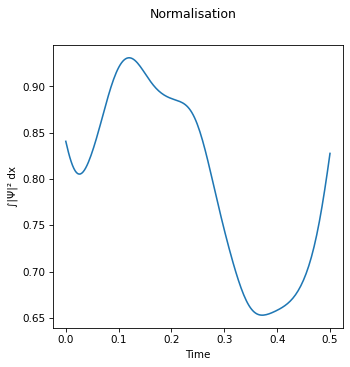

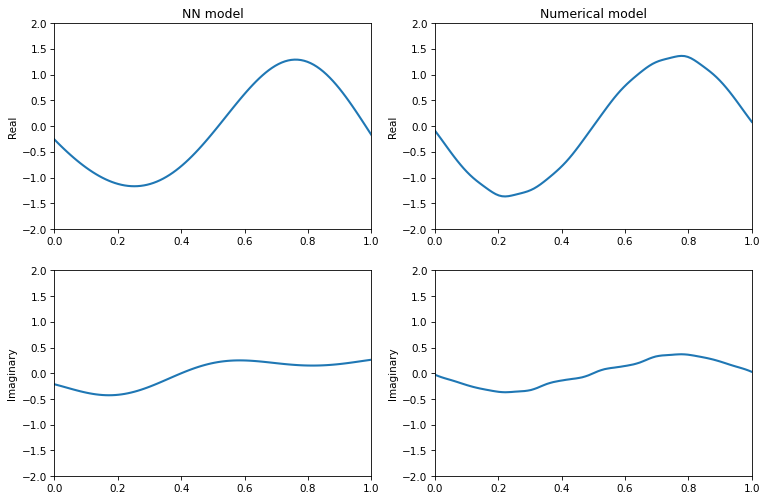

In [12]:
# Particle in a Box - First Excited State

def psi0(x):
    real = np.sqrt(2)*np.sin(2*np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=False)

Solving numerically...
Finished solving numerically.
Solving nn...
Finished solving nn.


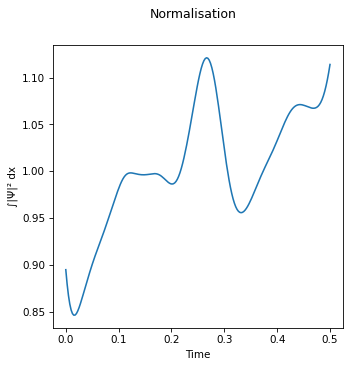

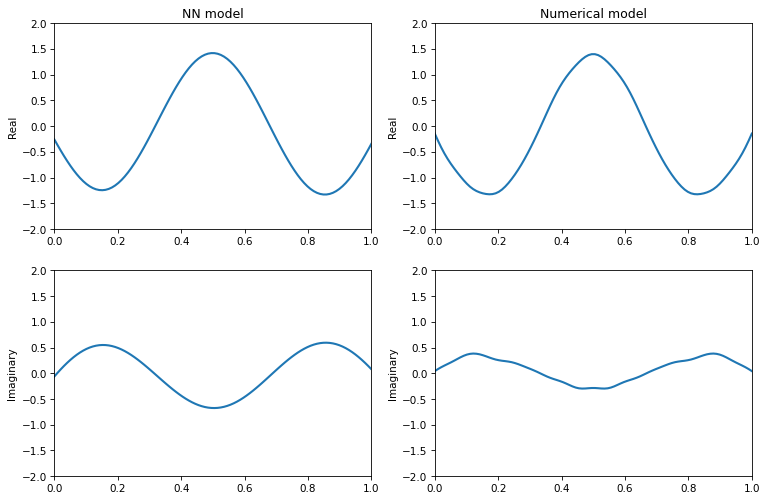

In [13]:
# Particle in a Box - Second Excited State

def psi0(x):
    real = np.sqrt(2)*np.sin(3*np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=False)

Solving numerically...
Finished solving numerically.
Solving nn...
Finished solving nn.


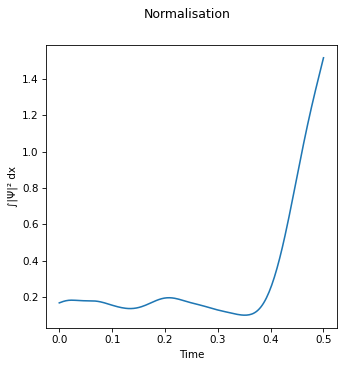

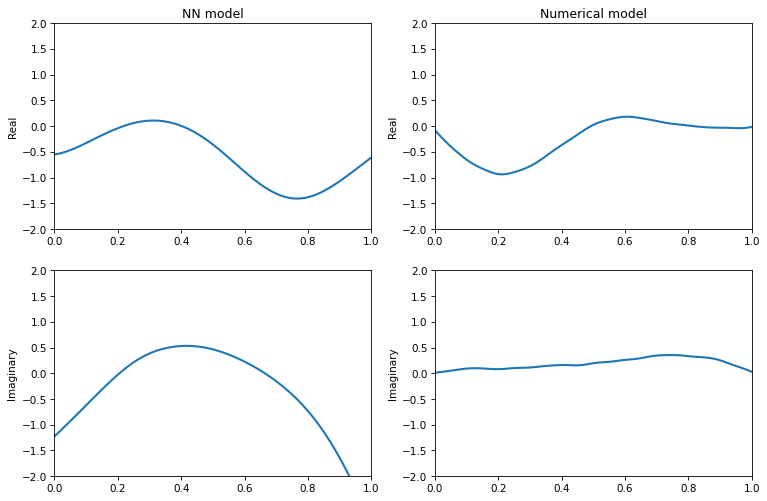

In [14]:
# Particle in a Box - Random Left-Heavy Thing

def psi0(x):
    real = 0.39086*np.sin(np.pi*x) + 0.497462*np.sin(2*np.pi*x) + 0.3197970*np.sin(3*np.pi*x)
    imag = 0*x
    return real, imag

def v0(x):
    return 0*x

test_model(psi0, v0, plot_phase=False)

In [ ]:
``

In [ ]:
% pip install xitorch

In [ ]:
import timeit

epoch_loss = 0
mse_loss = 0

def norm_loss_helper(x,inputs_clone):
    inputs_clone[:,0] = x
    outputs = model(inputs_clone)
    return outputs[:,0]**2 + outputs[:,1]**2

def help_me_again(inputs_clone, batch_size):
    xs = torch.linspace(0,1,100)
    thingy = torch.zeros((batch_size,)).to(device)
    for i in range(100):
        x = xs[i]
        inputs_clone[:,0] = x
        outputs = model(inputs_clone)
        thingy = thingy + (outputs[:,0]**2) + (outputs[:,1]**2)

    return thingy*0.01


def norm_loss(inputs):
    batch_size = output.shape[0]

    inputs_clone = inputs.clone()
    norms = xitorch.integrate.quad(norm_loss_helper, 0, 1, [inputs_clone], method="leggauss", n=10)
    return norms

N = 10
legendre_xs, legendre_ws = scipy.special.roots_legendre(N)
legendre_xs = (legendre_xs + 1.0)/2.0
legendre_xs = torch.tensor(legendre_xs).to(device).float()
legendre_ws = torch.tensor(legendre_ws).to(device).float()

def norm_2(inputs):
    N = 10
    batch_size = inputs.shape[0]
    inputs_clone = inputs.clone()
    #print(inputs_clone.shape)
    inputs_clone = inputs_clone.expand(N,-1,-1).clone()
    #print(inputs_clone.shape)
    xs_expanded = legendre_xs.expand(batch_size, -1).T
    inputs_clone[:,:,0] = xs_expanded
    #print(inputs_clone[:,0,0] - inputs_clone[:,1,0])
    # print('BEFORE CHECK')
    # print(inputs_clone[0,1,:])
    inputs_clone = torch.reshape(inputs_clone, (batch_size*N, -1))
    #p rint(inputs_clone[1,:])
    outputs = model(inputs_clone)
    # print('OUTPUTS')
    # print(outputs.shape)
    outputs = torch.reshape(outputs, (N, batch_size, -1))
    # print(outputs.shape)
    outputs = outputs[:,:,0]**2 + outputs[:,:,1]**2
    # print(outputs.shape)
    # print(outputs.dtype)
    norms = torch.inner(outputs.T, legendre_ws)/2
    
    return norms


for x,y in train_data_loader:
    x = x.to(device)
    x[:,1] = 0.01

    n1 = norm_loss(x)
    n2 = norm_2(x)

    print(n1/n2)

    t1 = timeit.timeit(lambda: norm_loss(x), number=100)
    t2 = timeit.timeit(lambda: norm_2(x), number=100)
    print(f't1 is {t1}. t2 is {t2}.')

    break

In [ ]:
import matplotlib.pyplot as plt

def schrodinger_loss(output, inputs):
    batch_size = output.shape[0]
    
    psi_real = output[:,0]
    psi_imag = output[:,1]

    plt.figure()
    plt.plot(np.linspace(0,1,100), psi_real.cpu().detach().numpy())
    plt.plot(np.linspace(0,1,100), psi_imag.cpu().detach().numpy())
    plt.title('psi')    
    
    # Calculate Laplacian
    # dx = 1e-4 # TODO Make sure the precsion of this is no less than the precision of input
    # inputs_x_minus = inputs.clone()
    # inputs_x_minus[:,0] -= dx
    # inputs_x_plus = inputs.clone()
    # inputs_x_plus[:,0] += dx
    
    # psi_x_minus = model(inputs_x_minus)
    # psi_x_plus = model(inputs_x_plus)
    # psi_d2x = (psi_x_plus + psi_x_minus - 2*output)/(dx**2)

    e_x = torch.zeros((batch_size,302)).to(device)
    e_x[:,0] = 1
    psi_dx = lambda i: torch.autograd.functional.jvp(model, i, v=e_x, create_graph=True)[1]
    psi_d2x = torch.autograd.functional.jvp(psi_dx, inputs, v=e_x, create_graph=True)[1]
    
    psi_d2x_real = psi_d2x[:,0]
    psi_d2x_imag = psi_d2x[:,1]

    plt.figure()
    plt.plot(np.linspace(0,1,100), psi_d2x_real.cpu().detach().numpy())
    plt.plot(np.linspace(0,1,100), psi_d2x_imag.cpu().detach().numpy())
    plt.title('d2x psi')
    
    # Calculate time derivative
    # dt = 1e-5
    # inputs_t_minus = inputs.clone()
    # inputs_t_minus[:,1] -= dt
    # inputs_t_plus = inputs.clone()
    # inputs_t_plus[:,1] += dt
    
    # psi_t_minus = model(inputs_t_minus)
    # psi_t_plus = model(inputs_t_plus)
    
    # psi_dt = (psi_t_plus - psi_t_minus)/(2*dt)
    
    e_t = torch.zeros((batch_size,302)).to(device)
    e_t[:,1] = 1
    psi_dt = torch.autograd.functional.jvp(model, inputs, v=e_t, create_graph=True)[1]
    
    psi_dt_real = psi_dt[:,0]
    psi_dt_imag = psi_dt[:,1]

    plt.figure()
    plt.plot(np.linspace(0,1,100), psi_dt_real.cpu().detach().numpy())
    plt.plot(np.linspace(0,1,100), psi_dt_imag.cpu().detach().numpy())
    plt.title('dt psi')
    
    # Calculate potential energy
    # V_grid = inputs[:,2*grid_size+2:]
    # V = batch_interp(V_grid,inputs[:,0])
    V = 0
    
    V_real = V * psi_real
    V_imag = V * psi_imag
    
    # Calculate loss
    diff_1 = psi_dt_real - 0.5*psi_d2x_imag + V_imag
    diff_2 = psi_dt_imag + 0.5*psi_d2x_real - V_real

    return torch.mean(diff_1**2 + diff_2**2)

xs = torch.linspace(0, 1, 100).float()
ts = torch.tensor([0]).float()
    
xts = torch.cartesian_prod(xs,ts)

print(xts.shape)

nn_in = torch.zeros((len(xts), 3*grid_size + 2))
nn_in[:,0:2] = xts
nn_in[:,2:102] = np.sqrt(2)*torch.sin(np.pi*xs)
nn_in = nn_in.to(device)

sl = schrodinger_loss(model(nn_in), nn_in)

print(f'schrod loss is {sl}')

In [ ]:
legendre_n = 100
legendre_xs, legendre_ws = scipy.special.roots_legendre(legendre_n)
legendre_xs = (legendre_xs + 1.0)/2.0
legendre_xs = torch.tensor(legendre_xs).to(device).float()
legendre_ws = torch.tensor(legendre_ws).to(device).float()

def energy_loss(inputs):
    # Reshape input to evalute at legendre_n number of points.
    batch_size = inputs.shape[0]
    inputs_clone = inputs.clone()
    inputs_clone = inputs_clone.expand(legendre_n,-1,-1).clone()
    xs_expanded = legendre_xs.expand(batch_size, -1).T
    inputs_clone[:,:,0] = xs_expanded
    inputs_clone = torch.reshape(inputs_clone, (batch_size*legendre_n, -1))

    # TODO below not needed since we don't have V(x) term yet. 
    psi = model(inputs_clone)
    psi = torch.reshape(psi, (legendre_n, batch_size, -1))
    # At this point we have outputs is (xs, batch, [real,imag])

    plt.figure()
    plt.plot(legendre_xs.cpu().detach().numpy(), psi.cpu().detach().numpy()[:,0,0])
    plt.plot(legendre_xs.cpu().detach().numpy(), psi.cpu().detach().numpy()[:,0,1])
    plt.title('psi')

    e_x = torch.zeros((inputs_clone.shape[0],302)).to(device)
    e_x[:,0] = 1
    psi_dx = torch.autograd.functional.jvp(model, inputs_clone, v=e_x, create_graph=True)[1]
    psi_dx = torch.reshape(psi_dx, (legendre_n, batch_size, -1))

    plt.figure()
    plt.plot(legendre_xs.cpu().detach().numpy(), psi_dx.cpu().detach().numpy()[:,0,0])
    plt.plot(legendre_xs.cpu().detach().numpy(), psi_dx.cpu().detach().numpy()[:,0,1])
    plt.title('psi_dx')

    # Now use <H> = int 0.5*(psi_dx) + V(x)[psi^2].
    psi_h_psi = 0.5*(psi_dx[:,:,0]**2 + psi_dx[:,:,1]**2) # + v(x)*(psi[:,:,0]**2 + psi[:,:,1]**2)
    expectation_energy_after = torch.inner(psi_h_psi.T, legendre_ws)/2

    print(f'expectation energy after is {expectation_energy_after[0]}')

    print('after expecation shape')
    print(expectation_energy_after.shape)

    # Calculate initial energy expectation
    psi_0_real = inputs[:,2:102]
    psi_0_imag = inputs[:,102:202]
    # v = inputs[:,202:]

    psi_0_real_dx = (psi_0_real[:,1:] - psi_0_real[:,:-1])*100 
    psi_0_imag_dx = (psi_0_imag[:,1:] - psi_0_imag[:,:-1])*100

    initial_expectation = torch.sum(0.5*(psi_0_real_dx**2 + psi_0_imag_dx**2), dim=1)/99

    print('initial expectation shape')
    print(initial_expectation.shape)

    print(f'expectation energy before is {initial_expectation[0]}')

    print(f'Relative difference is {torch.mean(expectation_energy_after / initial_expectation)}')

    return torch.mean((expectation_energy_after - initial_expectation)**2)



xs = torch.linspace(0, 1, 100).float()
ts = torch.tensor([0]).float()
    
xts = torch.cartesian_prod(xs,ts)

nn_in = torch.zeros((len(xts), 3*grid_size + 2))
nn_in[:,0:2] = xts
nn_in[:,2:102] = np.sqrt(2)*torch.sin(np.pi*xs)
nn_in = nn_in.to(device)

energy_loss = energy_loss(nn_in)

print(f'energy loss is {energy_loss}')